<a href="https://colab.research.google.com/github/terryspitz/ipython_notebooks/blob/master/deeper/deeperfont_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import TTF fonts and output training data: a series of point deltas (PX, PY) along with booleans for pen-up/pen-down and next-glyph.

In [ ]:
# To start a local runtime:
# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888


In [4]:
from enum import Enum, IntEnum
import math
import os
import glob
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image, ImageDraw, ImageChops, ImageFont
from IPython.display import display
import tensorflow as tf
print('np', np.__version__)
print('tf', tf.__version__)
np.set_printoptions(precision=2)
from google.colab import drive


np 1.18.5
tf 2.3.0


In [5]:
!pip install fonttools
from fontTools.ttLib import TTFont


     |████████████████████████████████| 819kB 2.8MB/s 


In [6]:
# Connect to Google Drive to read fonts
# from https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
#Read Font outlines from local font files and write outlines to file for fitting
def getCoordinates(font:TTFont, glyphName:str):
    """font, glyphName --> glyph coordinates as expected by "gvar" table
    The result includes four "phantom points" for the glyph metrics,
    as mandated by the "gvar" spec.
    Function from https://github.com/fonttools/fonttools/blob/master/Snippets/interpolate.py
    By inspection coords[0] are all points, and coords[1] are the end of the ranges for each contour (shape)
    """
    glyphTable = font["glyf"]
    glyph = glyphTable.glyphs.get(glyphName)
    if glyph is None:
        return None
    glyph.expand(glyphTable)
    glyph.recalcBounds(glyphTable)
    coords = glyph.getCoordinates(glyphTable)
    start=0
    contours = []
    for end in coords[1]:
        contours.append(coords[0][start:end+1])
        start=end+1
    return contours

COORDINATE_BITS = 8
MAX_COORD = 2**COORDINATE_BITS

class Stroke(IntEnum):
    """
    Enum defining data contents of last dimension
    """
    PX = 0
    PY = 1
    PenDown = 2  # +1 draw stroke, 0 if this stroke is hidden, i.e. to move between contours in the glyph
    EndOfGlyph = 3  # +1 indicates this stroke is the last of the current glyph, else 0
    Size = 4  # size of this enum
    

def generateOutlines(fontfile:str, glyphs:str, max_outline_points:int):
    """
    Read the actual points from all glyphs in the font into numpy array.
    Output is array of glyphs x points x Stroke.Size, dtype=int
    """
    font = TTFont(fontfile)
    scale = float(MAX_COORD) / font['head'].unitsPerEm * 1.2
    outlines = np.zeros((max_outline_points, Stroke.Size), np.int)
    j = 0
    for i, letter in enumerate(glyphs):
        contours = getCoordinates(font, letter)
        #ttx contours are areas within the glyph, like the outside and inside outlines of an O
        for xy in contours:
            #fill output matrix, start with hidden line to start position
            outlines[j,Stroke.PX] = xy[0][0] * scale
            outlines[j,Stroke.PY] = xy[0][1] * scale
            outlines[j,Stroke.PenDown] = 0
            j = j + 1
            if j>=max_outline_points: break
            for n in range(len(xy)-1):
                outlines[j,Stroke.PX] = xy[n+1][0] * scale
                outlines[j,Stroke.PY] = xy[n+1][1] * scale
                outlines[j,Stroke.PenDown] = 1
                j = j+1
                if j>=max_outline_points: break
            # #finally wrap last point to first in contour
            # outlines[j,Stroke.PX] = (xy[0][0]-xy[-1][0])/ unitsPerEm
            # outlines[j,Stroke.PY] = (xy[0][1]-xy[-1][1])/ unitsPerEm
            # outlines[j,Stroke.PenDown] = 1
            # j = j+1
            # if j>=max_outline_points: break
        outlines[j,Stroke.EndOfGlyph] = 1  # otherwise leave as 0
        j = j+1
    print(f"Font {fontfile} has {j} points, range(PX)= {outlines.min(axis=1)[Stroke.PX]},{outlines.max(axis=1)[Stroke.PX]}, range(PY)= {outlines.min(axis=1)[Stroke.PY]},{outlines.max(axis=1)[Stroke.PY]}")
    return outlines
  
def readFonts(files: [str], glyphs: str, max_outline_points:int):
    print('loading {} files'.format(len(files)))
    outlines = []
    for i, fontfile in enumerate(files):
        outlines.append(generateOutlines(fontfile, glyphs, max_outline_points))
    return np.stack(outlines)


In [8]:
print('setup...')
glyphs = []
# glyphs += [chr(i) for i in range(ord('A'), ord('Z')+1)]
glyphs += [chr(i) for i in range(ord('a'), ord('z')+1)]
# glyphs += ['zero','one','two','three','four','five','six','seven','eight','nine']
#glyphs = ['A','B','a','b','one','two']
#glyphs = ['one','two','one','two']
# glyphs = ['A'] + glyphs
max_points_per_scanline = 10 # required for g, m
max_outline_points = 2000
#local: files = glob.glob('deeper/fonts/*.ttf')
files = glob.glob('/content/drive/My Drive/Colab Notebooks/fonts/*.ttf')
outlines = readFonts(files, glyphs, max_outline_points)
# testoutlines = tf.constant([[[0.2,0.2,0,0],[0.6,0,1,0],[0,0.6,1,0],[-0.6,0,1,0],[0,-0.6,1,1]]], dtype=tf.float32)
# testoutlines = tf.tile(outlines, (1, 10, 1))
# testglyphs = ['A'] * 10


setup...
loading 8 files
Font /content/drive/My Drive/Colab Notebooks/fonts/AndikaNewBasic-BI.ttf has 1455 points, range(PX)= 0,118, range(PY)= 0,117
Font /content/drive/My Drive/Colab Notebooks/fonts/Courier Prime Bold.ttf has 1747 points, range(PX)= 0,123, range(PY)= 0,111
Font /content/drive/My Drive/Colab Notebooks/fonts/Courier Prime Italic.ttf has 1502 points, range(PX)= -3,72, range(PY)= -3,60
Font /content/drive/My Drive/Colab Notebooks/fonts/AndikaNewBasic-R.ttf has 1078 points, range(PX)= 0,114, range(PY)= 0,111
Font /content/drive/My Drive/Colab Notebooks/fonts/AndikaNewBasic-B.ttf has 1085 points, range(PX)= 0,115, range(PY)= 0,113
Font /content/drive/My Drive/Colab Notebooks/fonts/Courier Prime.ttf has 1502 points, range(PX)= 0,164, range(PY)= 0,169
Font /content/drive/My Drive/Colab Notebooks/fonts/Courier Prime Bold Italic.ttf has 1733 points, range(PX)= 0,117, range(PY)= 0,106
Font /content/drive/My Drive/Colab Notebooks/fonts/AndikaNewBasic-I.ttf has 1459 points, range

In [9]:
def drawOutlines(outlines, cellsize, glyphCount):
  """Draw outline tensor."""
  im = Image.new('1', size=(glyphCount*cellsize, outlines.shape[0]*cellsize), color=(0))
  def drawPoints(im, points):
    if len(points)<=2:
      return im
    #temporary image to use to xor each part with main image
    im2 = Image.new('1', size=(glyphCount*cellsize, outlines.shape[0]*cellsize), color=(0)) 
    draw = ImageDraw.Draw(im2).polygon(points, fill=1)
    return ImageChops.logical_xor(im, im2)
  scale = cellsize / MAX_COORD
  for font in range(outlines.shape[0]):
    i = 0
    for glyphNum in range(glyphCount):
      points = []
      x0,y0 = (glyphNum * cellsize, (font+1) * cellsize)
      #ImageDraw.Draw(im).line((glyphNum * cellsize, font * cellsize, glyphNum * cellsize, (font+1) * cellsize), fill=1)
      #ImageDraw.Draw(im).line((glyphNum * cellsize, font * cellsize, (glyphNum+1) * cellsize, font * cellsize), fill=1)
      while True:
        x = x0 + outlines[font,i,Stroke.PX]*scale
        y = y0 - outlines[font,i,Stroke.PY]*scale
        #print(outlines[font,i], x,y)
        if outlines[font,i,Stroke.PenDown]>0.5:
          points += (x,y)
        else:
          im = drawPoints(im, points)
          points=[(x,y)]
        i+=1
        if outlines[font,i,Stroke.EndOfGlyph]>0.5 or i>=outlines.shape[1]:
          break
      im = drawPoints(im, points)
  return im


outline shape (fonts, max_points_per_scanline, Stroke.Size):  (8, 2000, 4)


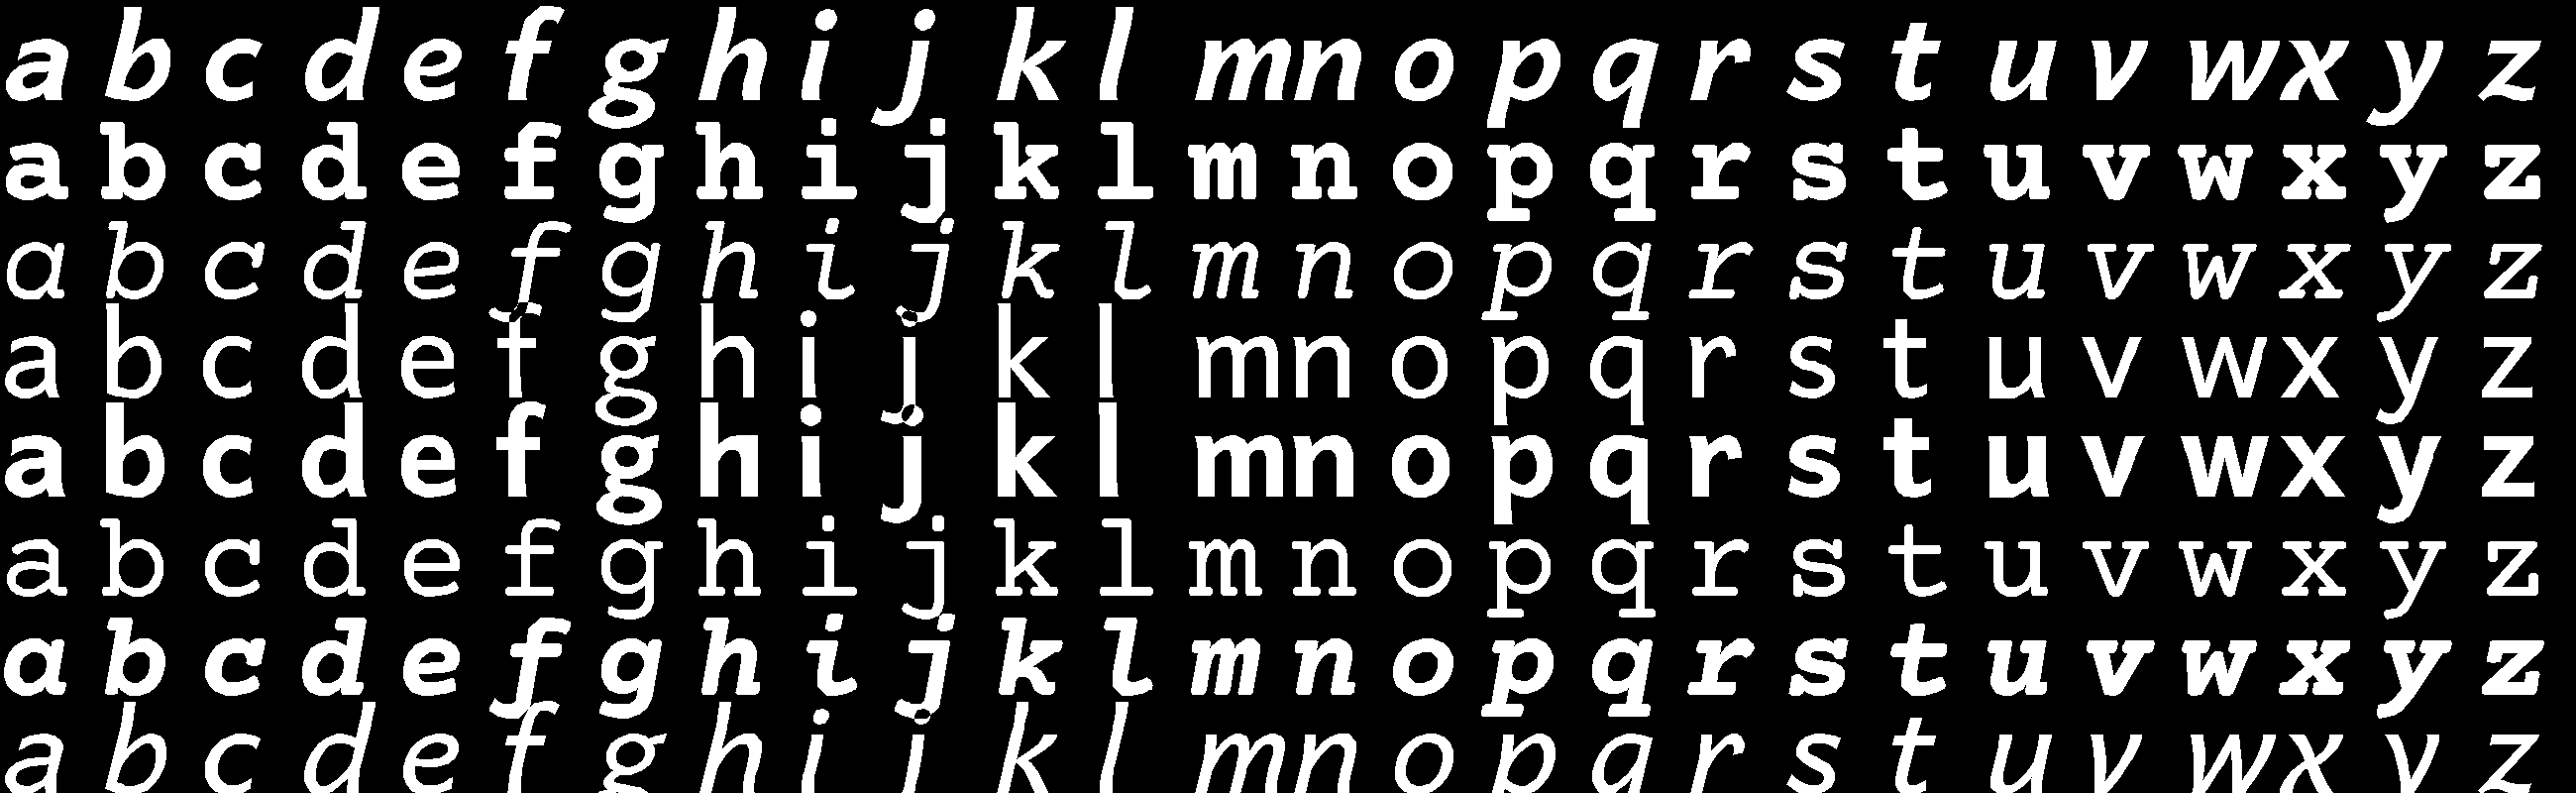

In [10]:
cellsize = 100

print("outline shape (fonts, max_points_per_scanline, Stroke.Size): ", outlines.shape)
display(drawOutlines(outlines, cellsize, len(glyphs)))


In [11]:
def outlinesToScanlines(outlines, max_points_per_scanline, ygrid, glyphCount):
    '''
    Pure tensorflow function
    Input: 2D tensor of max_outline_points * Stroke (PX,PY,PenDown,EndOfGlyph)
    Output: glyphCount * y coord * sorted x coords for each scanline
    '''
    glyphNums = tf.cast(outlines[:-1,Stroke.EndOfGlyph]>0.5, tf.int32)
    glyphNums = tf.cumsum(glyphNums, axis=-1)
    glyphNums = tf.concat((tf.zeros([1], dtype=tf.int32), glyphNums), axis=0)
    glyphNums2D = tf.expand_dims(tf.range(glyphCount),-1)
    glyphNums2D = tf.tile(glyphNums2D, [1,glyphNums.shape[0]])
    glyphNums2D = tf.math.equal(glyphNums2D, glyphNums)
    glyphNums2D = tf.cast(glyphNums2D, tf.float32)
    xs = tf.cast(outlines[:,Stroke.PX] * glyphNums2D, tf.float32) + 1e-2
    ys = tf.cast(outlines[:,Stroke.PY] * glyphNums2D, tf.float32) + 1e-2
    #offset to create line start x1,y1 to end x2,y2
    #add 3rd dimension (size=1) so following interpolation in y is broadcast across all lines
    x1s = tf.expand_dims(xs[:,:-1], -1)
    x2s = tf.expand_dims(xs[:,1:], -1)
    y1s = tf.expand_dims(ys[:,:-1], -1)
    y2s = tf.expand_dims(ys[:,1:], -1)
    #linear interpolate the x coords for all lines at all y coord
    xxs = x1s + (x2s-x1s)*(ygrid-y1s)/(y2s-y1s)
    #zero x coords outside of line y bounds or where PY=0 and for hidden lines
    in_range = tf.logical_or(tf.logical_and(y1s<ygrid, ygrid<=y2s), tf.logical_and(y2s<ygrid, ygrid<=y1s))
    in_range = tf.logical_and(in_range, y2s!=y1s)
    visible = outlines[1:,Stroke.PenDown]>0.5
    in_range = tf.logical_and(in_range, tf.expand_dims(visible,-1))
    xxs = tf.where(in_range, xxs, tf.zeros_like(xxs)) 
    return tf.nn.top_k(tf.transpose(xxs, perm=(0,2,1)), max_points_per_scanline).values
  
def drawScanLines(xxs, ygrid, cellsize):
    '''Draw a glyph rasterisation based on a input y coord array with array of x-intercepts of lines with the y coord'''
    columns = math.ceil(1000/cellsize)
    rows = 1 #math.ceil(xxs.shape[0]/columns)
    scale = float(cellsize) / MAX_COORD * 0.9
    im = Image.new('1', size=(columns*cellsize, rows*cellsize), color=(0)) 
    draw = ImageDraw.Draw(im) 
    for i in range(xxs.shape[0]):
      yy,xx = divmod(i, columns)
      xx *= cellsize
      yy = (yy+1)*cellsize-1
      for xs, y in zip(xxs[i], ygrid):
        for j in range(0, xs.shape[0], 2):
          if(xs[j]>1e-5):
            if(xs[j+1]>1e-5):
              draw.line((xx+xs[j]*scale, yy-y*scale, xx+xs[j+1]*scale, yy-y*scale), fill=1)
            else:
              draw.ellipse((xx+xs[j]*scale-1, yy-y*scale-1, xx+xs[j]*scale+1, yy-y*scale+1), fill=1)
    return im  

scanlines shape:  (26, 30, 10)


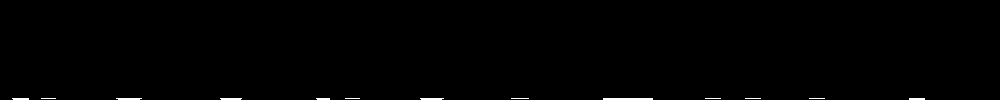

scanlines shape:  (26, 30, 10)


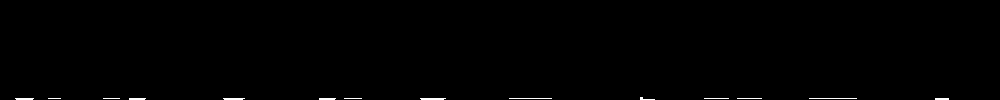

scanlines shape:  (26, 30, 10)


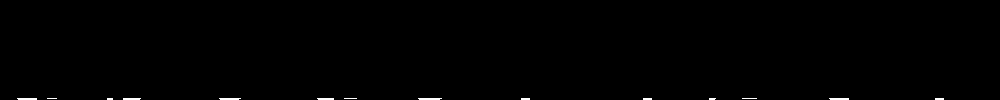

scanlines shape:  (26, 30, 10)


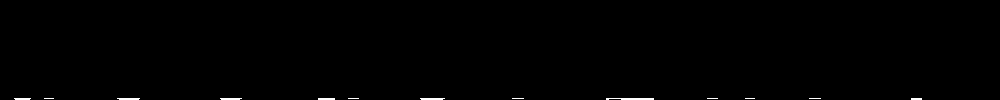

scanlines shape:  (26, 30, 10)


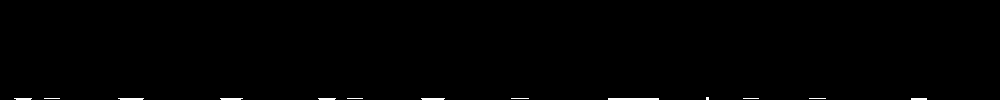

scanlines shape:  (26, 30, 10)


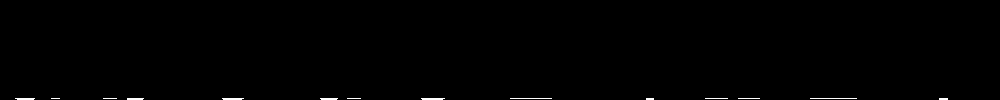

scanlines shape:  (26, 30, 10)


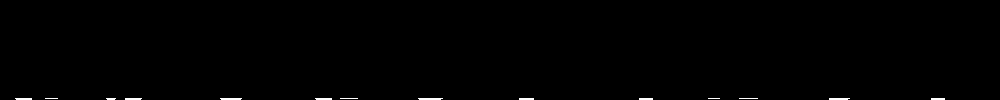

scanlines shape:  (26, 30, 10)


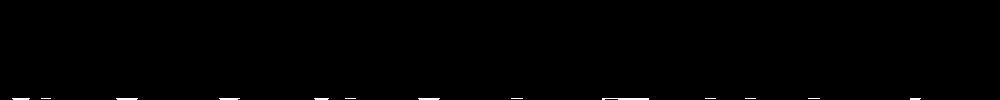

In [12]:
#test the TF scanline algorithm
ygrid = np.linspace(0.0, 1.0, 30, endpoint=False) #y coordinates to render on

for i in range(outlines.shape[0]):
  scanlines = outlinesToScanlines(outlines[i], max_points_per_scanline, ygrid, len(glyphs))
  print("scanlines shape: ", scanlines.shape)
  display(drawScanLines(scanlines, ygrid, cellsize))

In [19]:
# drive.mount('/content/drive')

# filename = r'C:\src\notebooks\deeper\fonts\fonts8.tfrecords'
# with open(filename, 'w') as writer:

filename = '/content/drive/My Drive/Colab Notebooks/fonts/fonts8b.tfrecords'
with tf.io.TFRecordWriter(filename) as writer:
  print('Writing', filename)
  for index in range(outlines.shape[0]):
    example = tf.train.Example(
      features=tf.train.Features(
        feature={
          'glyphNum': tf.train.Feature(int64_list=tf.train.Int64List(value=[len(glyphs)])),
          'outline': tf.train.Feature(int64_list=tf.train.Int64List(value=outlines[index].flatten().tolist())),
        }))
    writer.write(example.SerializeToString())


Writing /content/drive/My Drive/Colab Notebooks/fonts/fonts8b.tfrecords


In [31]:
def parse_proto(example_proto):
  features = {
    'glyphNum': tf.io.FixedLenFeature([], tf.int64),
    'outline': tf.io.FixedLenFeature([2000*4], tf.int64),
  }
  return tf.io.parse_single_example(example_proto, features)

buffer_size=10000
batch_size=10
#dataset = tf.python_io.tf_record_iterator(filename)
dataset = tf.data.TFRecordDataset(filename)
# for d in dataset:
#   print(parse_proto(d))
dataset = dataset.map(parse_proto)
dataset = dataset.shuffle(buffer_size)
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)

for next_element in dataset:
  print(next_element)
  assert next_element["glyphNum"].numpy()[0] == 63
  assert next_element["outline"].shape[0].value == batch_size
  assert next_element["outline"].shape[1].value == 20000
  break
  

{'glyphNum': <tf.Tensor: shape=(10,), dtype=int64, numpy=array([26, 26, 26, 26, 26, 26, 26, 26, 26, 26])>, 'outline': <tf.Tensor: shape=(10, 8000), dtype=int64, numpy=
array([[124,  72,   0, ...,   0,   0,   0],
       [114,  74,   0, ...,   0,   0,   0],
       [164,  20,   0, ...,   0,   0,   0],
       ...,
       [117,  19,   0, ...,   0,   0,   0],
       [115,  71,   0, ...,   0,   0,   0],
       [124,  72,   0, ...,   0,   0,   0]])>}


AssertionError: ignored